# Autoencoder for anomaly detection
This notebook shows an example on how to use autocoder to learn a low dimensional representation which enables anomaly detection in a downstream process.

In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from google.colab import drive
from numpy.linalg import norm

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
drive.mount('/content/gdrive')

Mounted at /content/gdrive




## Load data
The KDD99 dataset contains many columns that define the network state over time intervals during which a cyber attack might have taken place.  The column labeled "outcome" specifies either "normal," indicating no attack, or the type of attack performed.

In [2]:
df = pd.read_csv('/content/gdrive/My Drive/BT4012/Week 8/kddcup.csv')

In [3]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [4]:
# The following code displays the counts for each type of attack, as well as "normal".

df.outcome.value_counts()

smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: outcome, dtype: int64

## Preprocessing 

Before we feed the data into the autoencoder,  we transform numeric features into Z-Scores and replaces categorical features with dummy variables.

In [5]:
df.shape

(494021, 42)

In [6]:
# Drop is_host_login

df['is_host_login'].value_counts()

0    494021
Name: is_host_login, dtype: int64

In [7]:
df = df.drop('is_host_login', axis=1)

In [8]:
# Generate lists of categorical and numerical variables.

categorical_variables = []
numerical_variables = []

df_dtypes = pd.DataFrame(df.dtypes).reset_index().sort_values(by=0)

for index, row in df_dtypes.iterrows():
  if row[0] in ['int64', 'float64']:
    numerical_variables.append(row['index'])
  else:
    categorical_variables.append(row['index'])

categorical_variables.remove('outcome')

In [9]:
categorical_variables, numerical_variables

(['service', 'protocol_type', 'flag'],
 ['duration',
  'dst_host_srv_count',
  'dst_host_count',
  'srv_count',
  'count',
  'num_outbound_cmds',
  'num_access_files',
  'num_shells',
  'num_file_creations',
  'num_root',
  'su_attempted',
  'root_shell',
  'is_guest_login',
  'logged_in',
  'num_failed_logins',
  'hot',
  'urgent',
  'wrong_fragment',
  'land',
  'dst_bytes',
  'src_bytes',
  'num_compromised',
  'dst_host_rerror_rate',
  'dst_host_srv_serror_rate',
  'dst_host_serror_rate',
  'dst_host_srv_diff_host_rate',
  'dst_host_same_src_port_rate',
  'dst_host_diff_srv_rate',
  'dst_host_same_srv_rate',
  'srv_rerror_rate',
  'diff_srv_rate',
  'same_srv_rate',
  'rerror_rate',
  'srv_serror_rate',
  'serror_rate',
  'dst_host_srv_rerror_rate',
  'srv_diff_host_rate'])

### Feature preprocessing
We now use these steps to preprocess each of the columns. This code converts all numeric columns to Z-Scores and one-hot encodes all textual columns.

In [10]:
# Standard Scale the numerical values
scaler = StandardScaler()

for var in numerical_variables:
  df[var] = scaler.fit_transform(df[[var]])[:,0]

In [11]:
# One-hot encoding for the categorical variables
for var in categorical_variables:
  dummies = pd.get_dummies(df[var])
  df = df.drop(var, axis=1)
  df = pd.concat([df, dummies], axis=1)

## Train/Test split 

To perform anomaly detection, we divide the data into two groups "normal" and the various attacks. The following code divides the data into two dataframes and displays each of these two groups' sizes. 

In [12]:
normal_mask = df['outcome']=='normal.'
attack_mask = df['outcome']!='normal.'

df.drop('outcome',axis=1,inplace=True)

df_normal = df[normal_mask]
df_attack = df[attack_mask]

print(f"Normal count: {len(df_normal)}")
print(f"Attack count: {len(df_attack)}")

x_normal = df_normal.values
x_attack = df_attack.values

Normal count: 97278
Attack count: 396743


## Training the Autoencoder

It is important to note that we are not using the outcome column as a label to predict.  This anomaly detection is unsupervised; there is no target (y) value to predict. We will train an autoencoder on the normal data and see how well it can detect that the data not flagged as "normal" represents an anomaly. 

Next, we split the normal data into a 90% train and a 10% test set. 

In [13]:
from sklearn.model_selection import train_test_split

x_normal_train, x_normal_test = train_test_split(x_normal, test_size=0.1, random_state=1)

We display the size of the train and test sets.

In [14]:
print(f"Normal train count: {len(x_normal_train)}")
print(f"Normal test count: {len(x_normal_test)}")

Normal train count: 87550
Normal test count: 9728


We are now ready to train the autoencoder on the normal data. The autoencoder will learn to compress the data to a vector with 3 dimensions. 

In [15]:
from sklearn import metrics
import numpy as np
import pandas as pd
from IPython.display import display, HTML 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow import keras

tf.keras.backend.set_floatx('float64')
model = Sequential()
model.add(Dense(25, activation='relu'))
model.add(Dense(3, activation='relu')) # size to compress to
model.add(Dense(25, activation='relu'))
model.add(Dense(x_normal.shape[1])) 
model.compile(loss='mean_squared_error', optimizer='nadam')
history = model.fit(x_normal_train,
                    x_normal_train,
                    epochs=100,
                    batch_size=50,
                    validation_split=0.1
                   )

Epoch 1/100
1576/1576 [==============================] - 5s 3ms/step - loss: 0.3402 - val_loss: 0.3440
Epoch 2/100
1576/1576 [==============================] - 5s 3ms/step - loss: 0.2817 - val_loss: 0.3171
Epoch 3/100
1576/1576 [==============================] - 5s 3ms/step - loss: 0.2646 - val_loss: 0.2965
Epoch 4/100
1576/1576 [==============================] - 5s 3ms/step - loss: 0.2505 - val_loss: 0.2712
Epoch 5/100
1576/1576 [==============================] - 5s 3ms/step - loss: 0.2333 - val_loss: 0.2396
Epoch 6/100
1576/1576 [==============================] - 5s 3ms/step - loss: 0.2182 - val_loss: 0.2210
Epoch 7/100
1576/1576 [==============================] - 5s 3ms/step - loss: 0.2116 - val_loss: 0.2149
Epoch 8/100
1576/1576 [==============================] - 5s 3ms/step - loss: 0.2073 - val_loss: 0.2133
Epoch 9/100
1576/1576 [==============================] - 5s 3ms/step - loss: 0.2068 - val_loss: 0.2133
Epoch 10/100
1576/1576 [==============================] - 5s 3ms/step - l

[(0.1488811077278322, 0.41277609602646576)]

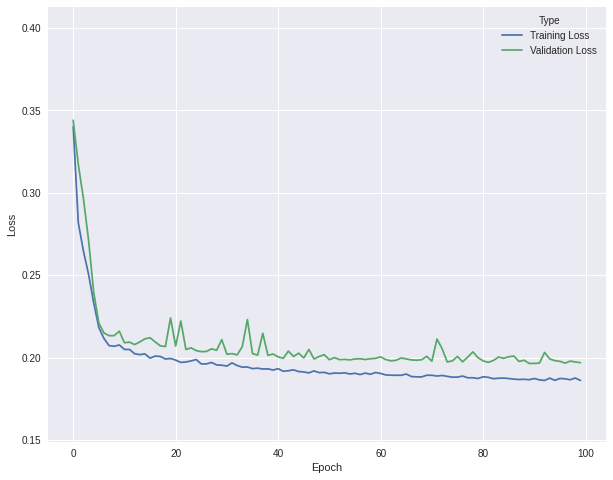

In [20]:
# Visualize the training and validation loss

losses = history.history['loss'] + history.history['val_loss']
types = ['Training Loss'] * len(history.history['loss']) + ['Validation Loss'] * len(history.history['val_loss'])
epoches = history.epoch + history.epoch
df_losses = pd.DataFrame({'Loss': losses, 'Epoch':epoches, 'Type': types})

plt.figure(figsize=(10, 8))
ax = sns.lineplot(data=df_losses, x='Epoch', y='Loss', hue='Type')
ax.set(ylim=(min(df_losses['Loss']) * 0.8, max(df_losses['Loss']) * 1.2))

## Detecting an Anomaly

We are now ready to see if the abnormal data registers as an anomaly. 
- The first score shows the insample RMSE error.
- The second score shows the out-of-sample RMSE error.
- The first score is low as they resulted from normal data.
- The much higher error occurred from the abnormal data as the autoencoder is not as capable of encoding data that represets an attack. 
- This higher error indicates an anomaly.

In [21]:
pred_normal = model.predict(x_normal)
score_normal = metrics.mean_squared_error(pred_normal, x_normal)

pred_anomaly = model.predict(x_attack)
score_anomaly = metrics.mean_squared_error(pred_anomaly, x_attack)

print(f"Insample Normal Score (RMSE): {score_normal}")
print(f"Attack Underway Score (RMSE): {score_anomaly}")

Insample Normal Score (RMSE): 0.2569971589714577
Attack Underway Score (RMSE): 0.6273730367312794


## Next, we generate the distribution of RMSE for both normal and attack data

In [23]:
diff_normal = pred_normal - x_normal
diff_anomaly = pred_anomaly - x_attack

scores_normal = np.power(diff_normal, 2).flatten()
scores_anomaly = np.power(diff_anomaly, 2).flatten()

df_normal = pd.DataFrame({'normal': scores_normal})
df_anomaly = pd.DataFrame({'anomaly': scores_anomaly})

df_comparison = pd.concat([df_normal.describe(), df_anomaly.describe()], axis=1)

df_comparison

,normal,anomaly
count,1.138153e+07,4.641893e+07
mean,2.569972e-01,6.273730e-01
std,1.650865e+02,8.045040e+01
min,2.638424e-22,9.175838e-20
25%,6.094355e-07,3.173459e-05
50%,3.832799e-06,1.778711e-04
75%,1.290979e-04,2.159755e-02
max,2.964149e+05,4.922274e+05


In [39]:
normal_scores, anomaly_scores = [], []

for p in range(50, 100, 5):
  normal_scores.append(np.percentile(scores_normal, p))
  anomaly_scores.append(np.percentile(scores_anomaly, p))

percentile_values = pd.DataFrame({'Percentile': range(50, 100, 5), 
                                  'Score Normal': normal_scores, 
                                  'Score Anomaly': anomaly_scores})
percentile_values

,Percentile,Score Normal,Score Anomaly
0,50,0.000004,0.000178
1,55,0.000006,0.000269
2,60,0.000010,0.000649
3,65,0.000021,0.003605
4,70,0.000052,0.009832
5,75,0.000129,0.021598
6,80,0.000333,0.049856
7,85,0.000906,0.140991
8,90,0.002740,0.355025
9,95,0.012315,1.433943
